## Calculate the rate of work done by the component of the atm/ice/oce interfacial stress along the direction of the velocity of the medium lying underneath:  

### $W=\tau\cdot\mathbf{u}$, where $\tau$ is the stress and $\mathbf{u}$ is the velocity of the medium.   

### The stress depends on the motion of both media above and below the interface (see text below for more details).  

Chris Wilson, Oct. 2025.

### Import packages

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from joblib import Parallel, delayed



### Define string arrays of the filenames containing the input variables to be read. 

In [2]:
fnames_i=sorted(glob.glob('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/????/*icemod.nc'))

fnames_U=sorted(glob.glob('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/????/*grid_U.nc'))

fnames_V=sorted(glob.glob('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/????/*grid_V.nc'))

### Read the domain_cfg.nc file to get grid scale factors, etc.

In [3]:
domain_cfg=xr.open_dataset('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/domain/domain_cfg.nc')

### Subsample only the part of the global grid needed for this analysis.  
### Calculate the area at T-points on the model grid, to use later for area-weighting.
### Define a landmask.

In [4]:
# --- Precompute masked area and landmask ---
y_bounds = slice(2880, 3606)
mask_lat_threshold = 65.0

e1t=domain_cfg.e1t.sel(y=y_bounds)
e2t=domain_cfg.e2t.sel(y=y_bounds)
closea_mask_sub=domain_cfg.closea_mask.sel(y=y_bounds)


area_t_sub=e1t*e2t
lat = domain_cfg.nav_lat.sel(y=y_bounds)
mask = lat >= 65.0

area_t_sub_masked = area_t_sub.where(mask).squeeze()

landmask_sub=(1+closea_mask_sub)/(1+closea_mask_sub)  # ensures that the values > 1 in closea mask are handled, as well as preventing division by zero
landmask_sub_masked = landmask_sub.where(mask).squeeze()


## Calculate the rate of work done by the component of the atm/ice/oce interfacial stress along the direction of the velocity of the medium lying underneath.

In general, this is of the form

\begin{equation}
W_{pq}=\mathbf{\tau_{pq}}\cdot\mathbf{u_q},
\end{equation}

where $p$ and $q$ refer to the regions above and below the interface, respectively, $W_{pq}$ is the rate of work ($Wm^{-2}$), $\mathbf{\tau_{pq}}$ is the stress at the interface, and $\mathbf{u_q}$ is the velocity of the region below the interface.

However, as we're using monthly-mean fields in the calculation, the equation becomes 

\begin{equation}
W_{pq}^\ast=\overline{\mathbf{\tau_{pq}}}\cdot\overline{\mathbf{u_q}},
\end{equation}

where $\overline{[\,\,]}$ represents a monthly mean.  Note that $W_{pq}^\ast$ is not the monthly-mean work, as it excludes the quadratic contribution from time variations in stress and velocity. i.e.

\begin{equation}
\overline{W_{pq}}=W_{pq}^\ast+\overline{\mathbf{\tau_{pq}}'\cdot\mathbf{u_q}'},
\end{equation}

where the prime represents the deviation from the monthly mean: $[\,\,]=\overline{[\,\,]}+[\,\,]'$.

**Note that here we are calculating (the area integral per gridcell of) $W_{pq}^\ast$ NOT $\overline{W_{pq}}$ !**  >>>  This is the rate of work done, excluding covariance due to sub-monthly time variations in the stress and velocity.

**For brevity, let's relabel the area integral per gridcell** of $W_{pq}^\ast$ simply as $W_{pq}^\ast$, with units of Watts.

### Define some parameters used in the looping analysis, the variable names needed for the calculation, and some I/O filename paths.

In [5]:
ntimes_total = np.size(fnames_i)
start_time = 107 # corresponding to January 1990
var_groups = {
    'i': ['siconc', 'utau_oi', 'utau_ai', 'vtau_oi', 'vtau_ai', 'sivelu', 'sivelv'],
    'U': ['tauuo', 'uos'],
    'V': ['tauvo', 'vos']
}

# --- Input/output directories ---
input_base = Path("/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly")
output_base = Path("/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress")
output_base.mkdir(parents=True, exist_ok=True)

### Define a function to load a file, subsample its grid, apply a latitude mask, for a given variable name (rather than read all variables in the file).  Drop some irrelevant variables.

In [6]:
def load_subset(fname, y_bounds, varnames, mask_lat_threshold):
    out = {}
    with xr.open_dataset(fname, engine='netcdf4',
                         chunks={'y': 256, 'x': 256, 'time_counter': 1}) as ds:
        subset = ds.sel(y=y_bounds)
        mask = subset.nav_lat >= mask_lat_threshold
        for var in varnames:
            if var in ds:
                da = subset[var].where(mask).squeeze()
                drop_vars = ['time_centered_bounds', 'time_counter_bounds']
                out[var] = da.drop_vars(drop_vars, errors='ignore')
    return out

### Define a function to load all the variables needed for the W calculations for a given month.

In [7]:
def load_all_vars_for_month(fnames_i, fnames_U, fnames_V, y_bounds, var_groups, mask_lat_threshold):
    data = {}
    data.update(load_subset(fnames_i, y_bounds, var_groups['i'], mask_lat_threshold))
    data.update(load_subset(fnames_U, y_bounds, var_groups['U'], mask_lat_threshold))
    data.update(load_subset(fnames_V, y_bounds, var_groups['V'], mask_lat_threshold))
    return data

### Define a function to compute the three types of W term, returning them as an Xarray DataSet.

In [8]:
def compute_W_terms(block_data, area_t_sub_masked, landmask_sub):
    W_ao = ((block_data['tauuo']*block_data['uos'] + block_data['tauvo']*block_data['vos'])
            * area_t_sub_masked * landmask_sub)
    W_ai = ((block_data['utau_ai']*block_data['sivelu'] + block_data['vtau_ai']*block_data['sivelv'])
            * area_t_sub_masked * landmask_sub)
    W_io = ((-block_data['utau_oi']*block_data['uos'] - block_data['vtau_oi']*block_data['vos'])
            * area_t_sub_masked * landmask_sub)
    return xr.Dataset({'W_ao': W_ao, 'W_ai': W_ai, 'W_io': W_io})

### Define a wrapper function to process all 12 months in a given year (to be run on one worker, as a parallel job).

In [8]:
# --- Define the function to process one year (runs on one worker) ---
def process_year(year):
    print(f"🔹 Starting year {year}")
    year_dir = input_base / str(year)
    if not year_dir.exists():
        print(f"⚠️ Missing directory for {year}, skipping.")
        return

    out_dir = output_base / str(year)
    out_dir.mkdir(parents=True, exist_ok=True)

    for month in range(1, 13):
        mm = f"{month:02d}"
        print(f"  → Processing {year}-{mm}")

        try:
            fname_i = year_dir / f"eORCA12_MED_UKESM_y{year}m{mm}_icemod.nc"
            fname_U = year_dir / f"eORCA12_MED_UKESM_y{year}m{mm}_grid_U.nc"
            fname_V = year_dir / f"eORCA12_MED_UKESM_y{year}m{mm}_grid_V.nc"

            if not (fname_i.exists() and fname_U.exists() and fname_V.exists()):
                print(f"  ⚠️ Missing file(s) for {year}-{mm}, skipping.")
                continue

            # Load and compute
            block_data = load_all_vars_for_month(
                fname_i, fname_U, fname_V, y_bounds, var_groups, mask_lat_threshold
            )
            W_ds = compute_W_terms(block_data, area_t_sub_masked, landmask_sub)

            out_fname = out_dir / f"W_terms_y{year}m{mm}.nc"
            W_ds.to_netcdf(out_fname)

        except Exception as e:
            print(f"  ❌ Error for {year}-{mm}: {e}")

        finally:
            del block_data, W_ds
            gc.collect()

    print(f"✅ Finished {year}")

### Execute the parallel job, covering each year in the range 1990-2099, inclusive.

In [10]:
%%time
# --- Parallel execution ---
years = list(range(1990, 2100))
os.environ["OMP_NUM_THREADS"] = "2"  # The JASMIN Jupyter Notebook server has dual-threaded CPU cores
Parallel(n_jobs=12, prefer="processes")(delayed(process_year)(y) for y in years)  # This example uses 12 cores 

print("🎯 All years processed successfully.")

🔹 Starting year 1999🔹 Starting year 1990

🔹 Starting year 1992
🔹 Starting year 1991
🔹 Starting year 1997
🔹 Starting year 2001
🔹 Starting year 2000
🔹 Starting year 1998
🔹 Starting year 1995🔹 Starting year 1993

🔹 Starting year 1996
🔹 Starting year 1994
  → Processing 2000-01
  → Processing 1990-01
  → Processing 1997-01
  → Processing 1995-01
  → Processing 1998-01
  → Processing 1994-01
  → Processing 2001-01
  → Processing 1993-01
  → Processing 1992-01
  → Processing 1999-01
  → Processing 1991-01
  → Processing 1996-01
  → Processing 1993-02
  → Processing 1995-02
  → Processing 1992-02
  → Processing 1994-02
  → Processing 1997-02
  → Processing 1999-02
  → Processing 1996-02
  → Processing 1990-02
  → Processing 1998-02
  → Processing 2001-02
  → Processing 1991-02
  → Processing 2000-02
  → Processing 1993-03
  → Processing 1992-03
  → Processing 1996-03
  → Processing 1999-03
  → Processing 1997-03
  → Processing 1995-03
  → Processing 1994-03
  → Processing 1991-03
  → Processi

In [9]:
test_month=load_all_vars_for_month('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/1990/eORCA12_MED_UKESM_y1990m01_icemod.nc','/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/1990/eORCA12_MED_UKESM_y1990m01_grid_U.nc','/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/monthly/1990/eORCA12_MED_UKESM_y1990m01_grid_V.nc',y_bounds ,var_groups,mask_lat_threshold)



wtest_month=compute_W_terms(test_month, area_t_sub_masked, landmask_sub)

In [10]:
wtest_month

<xarray.Dataset> Size: 100MB
Dimensions:        (y: 726, x: 4322)
Coordinates:
    time_centered  object 8B 1990-01-16 00:00:00
    time_counter   object 8B 1990-01-16 00:00:00
    nav_lat        (y, x) float32 13MB dask.array<chunksize=(192, 256), meta=np.ndarray>
    nav_lon        (y, x) float32 13MB dask.array<chunksize=(192, 256), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    W_ao           (y, x) float64 25MB dask.array<chunksize=(192, 256), meta=np.ndarray>
    W_ai           (y, x) float64 25MB dask.array<chunksize=(192, 256), meta=np.ndarray>
    W_io           (y, x) float64 25MB dask.array<chunksize=(192, 256), meta=np.ndarray>

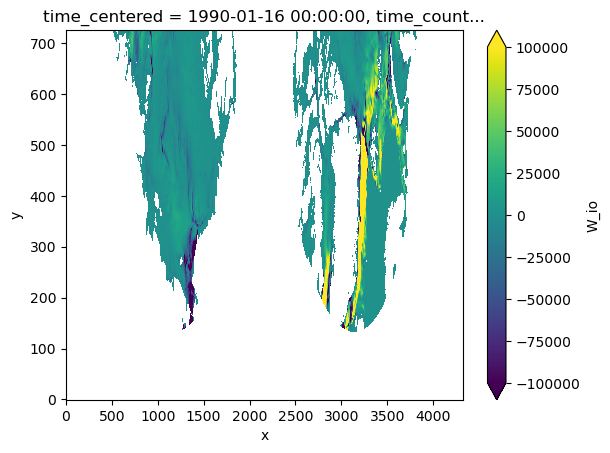

In [11]:
wtest_month.W_io.plot(vmin=-1e5,vmax=1e5)

## As all the monthly means from 1990-2099 have already been calculated, you can simply read them....

In [13]:
!ls /gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/plots_W_terms/

W_terms_y1990m01_month03d.png  W_work_1990_month011.png
W_terms_y2000m01_month03d.png  W_work_2000_month000.png
W_work_1990_month000.png       W_work_2000_month001.png
W_work_1990_month001.png       W_work_2000_month002.png
W_work_1990_month002.png       W_work_2000_month003.png
W_work_1990_month003.png       W_work_2000_month004.png
W_work_1990_month004.png       W_work_2000_month005.png
W_work_1990_month005.png       W_work_2000_month006.png
W_work_1990_month006.png       W_work_2000_month007.png
W_work_1990_month007.png       W_work_2000_month008.png
W_work_1990_month008.png       W_work_2000_month009.png
W_work_1990_month009.png       W_work_2000_month010.png
W_work_1990_month010.png       W_work_2000_month011.png
